In [47]:
import datetime as dt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, f1_score, accuracy_score, precision_score

from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Supervised Learning - problem regresji - PCA

## Eksploracyjna Analiza Danych (EDA - Exploratory Data Analysis)

wczytanie danych, przekształcenie dat

In [48]:
bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw['dteday'] = pd.to_datetime(bike_data_raw['dteday'])
bike_data_raw.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


informacje o danych

In [49]:
bike_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  rentals     731 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage: 80.1 KB


In [50]:
bike_data_raw.rentals.describe()

count     731.000000
mean      848.176471
std       686.622488
min         2.000000
25%       315.500000
50%       713.000000
75%      1096.000000
max      3410.000000
Name: rentals, dtype: float64

In [51]:
print('Przed usunięciem:')
display(bike_data_raw.head(5))
print('Po usunięciu:')
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday','yr'], axis=1, inplace=True)
display(bike_data.head(5))

Przed usunięciem:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


Po usunięciu:


,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


In [52]:
numeric_features = bike_data.columns[6:-1].to_list()
categorical_features = bike_data.columns[:6].to_list()
target = 'rentals'

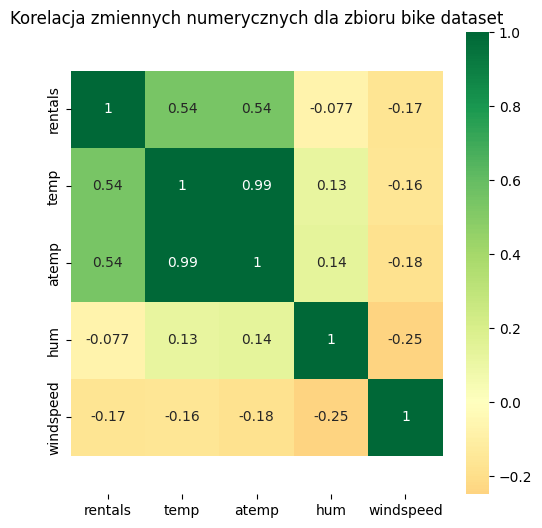

In [53]:
plt.figure(figsize=(6,6))
ax = sns.heatmap(
        bike_data[[target]+numeric_features].corr(),
        xticklabels=bike_data[[target]+numeric_features].corr().columns,
        yticklabels=bike_data[[target]+numeric_features].corr().columns,
        cmap='RdYlGn',
        center=0,
        annot=True
                )
plt.title('Korelacja zmiennych numerycznych dla zbioru bike dataset', fontsize=12)
bottom, top = ax.get_ylim()
ax.set_ylim([bottom+0.5, top-0.5])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [54]:
bike_data['difference_temp'] = (bike_data['atemp']-bike_data['temp'])/bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)
numeric_features.remove('atemp')
numeric_features.append('difference_temp')

### Zbiór treningowy i testowy

In [55]:
X, y = bike_data[numeric_features+categorical_features].copy(), bike_data[[target]].copy()

In [56]:
X.head(3)

,temp,hum,windspeed,difference_temp,season,mnth,holiday,weekday,workingday,weathersit
0,0.344167,0.805833,0.160446,0.056537,1,1,0,6,0,2
1,0.363478,0.696087,0.248539,-0.026794,1,1,0,0,0,2
2,0.196364,0.437273,0.248309,-0.035439,1,1,0,1,1,1


In [57]:
y.head(3)

,rentals
0,331
1,131
2,120


In [58]:
numeric_features, target

(['temp', 'hum', 'windspeed', 'difference_temp'], 'rentals')

## Wstępna analiza danych

### Analiza zmiennych numerycznych

In [59]:
X[numeric_features].head(2)

,temp,hum,windspeed,difference_temp
0,0.344167,0.805833,0.160446,0.056537
1,0.363478,0.696087,0.248539,-0.026794


In [60]:
X[numeric_features].describe()

,temp,hum,windspeed,difference_temp
count,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.627894,0.190486,-0.030268
std,0.183051,0.142429,0.077498,0.055104
min,0.059130,0.000000,0.022392,-0.664885
25%,0.337083,0.520000,0.134950,-0.063885
50%,0.498333,0.626667,0.180975,-0.032756
75%,0.655417,0.730209,0.233214,-0.008125
max,0.861667,0.972500,0.507463,0.337207


#### Graficzna reprezentacja wybranych cech

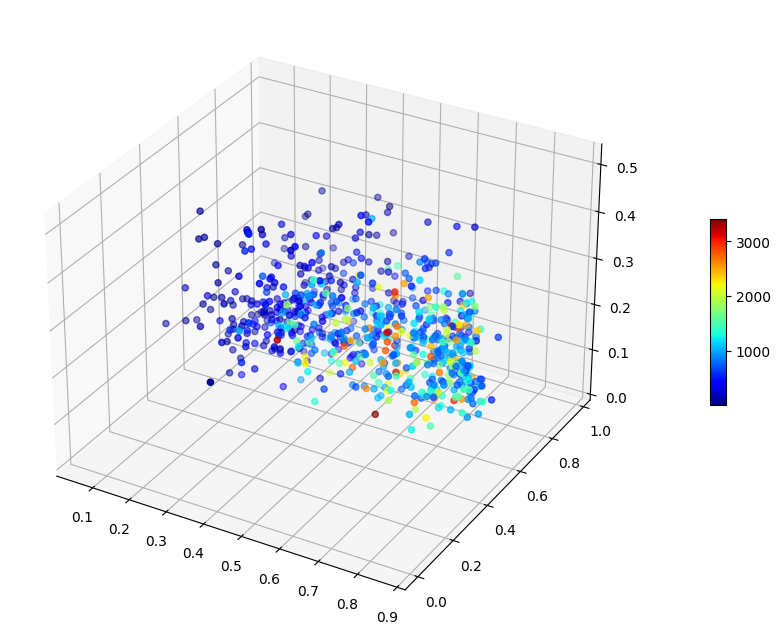

In [61]:
from matplotlib import cm # for a scatter plot

fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(xs=X[numeric_features].temp, ys=X[numeric_features].hum, zs=X[numeric_features].windspeed, c=y, cmap=cm.jet)
cax = fig.add_axes([ax.get_position().x1+0.10, ax.get_position().y0+0.14, 0.02, ax.get_position().height*0.3])
fig.colorbar(img, cax=cax)
plt.show()

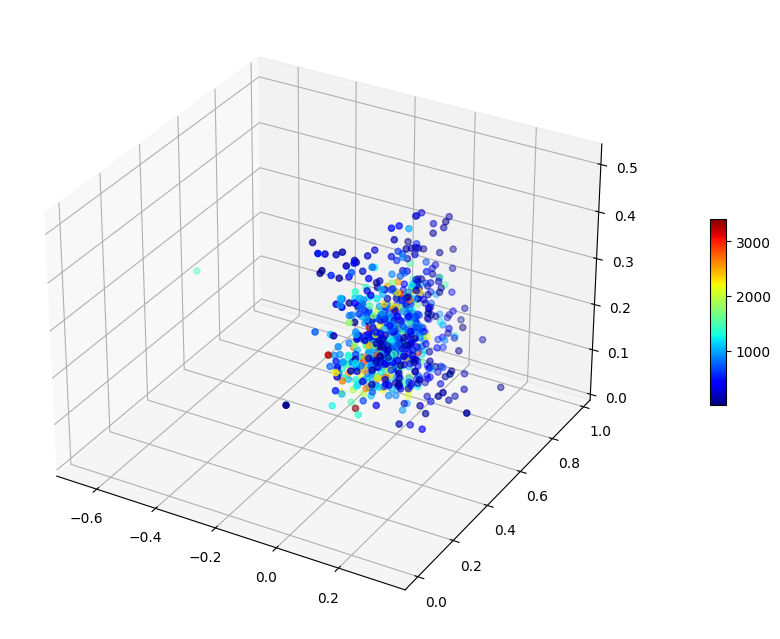

In [62]:
from matplotlib import cm # for a scatter plot

fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(xs=X[numeric_features].difference_temp, ys=X[numeric_features].hum, zs=X[numeric_features].windspeed, c=y, cmap=cm.jet)
cax = fig.add_axes([ax.get_position().x1+0.10, ax.get_position().y0+0.14, 0.02, ax.get_position().height*0.3])
fig.colorbar(img, cax=cax)
plt.show()

#### Skalowanie zmiennych

Skalowanie zmiennych do głównych składowych

array([[0.3551696 , 0.82862005, 0.2846062 , 0.71991516],
       [0.37923205, 0.71577069, 0.46621455, 0.63675869],
       [0.1709998 , 0.44963805, 0.4657404 , 0.62813137],
       ...,
       [0.24198597, 0.77420771, 0.21026043, 0.62043013],
       [0.2451011 , 0.49700051, 0.67693615, 0.56936252],
       [0.19525913, 0.59383033, 0.27306151, 0.69888525]])

,PC_0,PC_1,PC_2,PC_3
0,0.149828,-0.205806,0.115168,-0.047464
1,0.171623,0.016634,0.128339,0.008055
2,0.411374,0.110661,-0.086510,0.050248


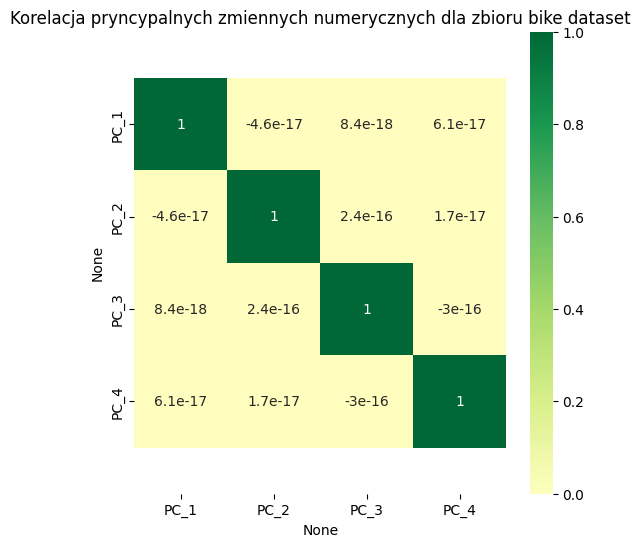

In [63]:
scaler = MinMaxScaler()
pca = PCA(random_state=42)

X_scaler = scaler.fit_transform(X[numeric_features])
X_pca = pca.fit_transform(X_scaler)

display(X_scaler)

df_X_PCA = pd.DataFrame(data=X_pca, columns=[[f'PC_{i}' for i in range(4)]])
display(df_X_PCA.head(3))

plt.figure(figsize=(6,6))
ax = sns.heatmap(
        df_X_PCA.corr(),
        xticklabels=['PC_1', 'PC_2', 'PC_3', 'PC_4'],
        yticklabels=['PC_1', 'PC_2', 'PC_3', 'PC_4'],
        cmap='RdYlGn',
        center=0,
        annot=True
                )
plt.title('Korelacja pryncypalnych zmiennych numerycznych dla zbioru bike dataset', fontsize=12)
bottom, top = ax.get_ylim()
ax.set_ylim([bottom+0.5, top-0.5])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Główne składowe nie są skorelowane

Ponowne skalowanie zmiennych po transformacji do głównych składowych

,PC_0,PC_1,PC_2,PC_3
0,0.566935,0.215179,0.626960,0.264247
1,0.588068,0.401247,0.641574,0.330971
2,0.820530,0.479898,0.403190,0.381680


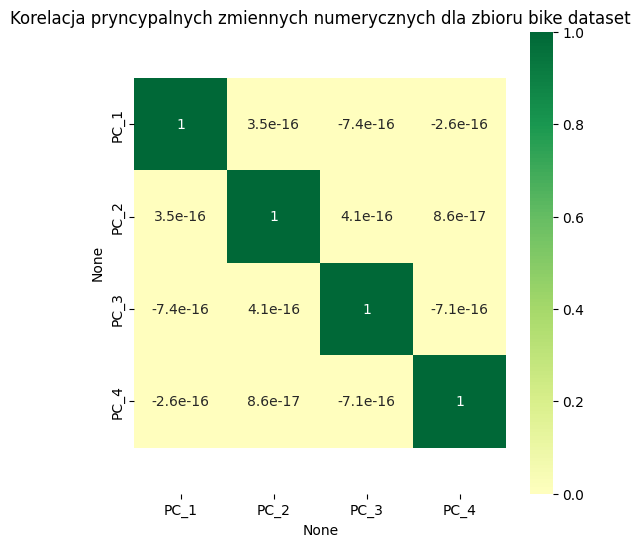

In [64]:
scaler = MinMaxScaler()
X_pca_rescaled = scaler.fit_transform(X_pca)

df_X_PCA_rescaled = pd.DataFrame(data=X_pca_rescaled, columns=[[f'PC_{i}' for i in range(4)]])
display(df_X_PCA_rescaled.head(3))

plt.figure(figsize=(6,6))
ax = sns.heatmap(
        df_X_PCA_rescaled.corr(),
        xticklabels=['PC_1', 'PC_2', 'PC_3', 'PC_4'],
        yticklabels=['PC_1', 'PC_2', 'PC_3', 'PC_4'],
        cmap='RdYlGn',
        center=0,
        annot=True
                )
plt.title('Korelacja pryncypalnych zmiennych numerycznych dla zbioru bike dataset', fontsize=12)
bottom, top = ax.get_ylim()
ax.set_ylim([bottom+0.5, top-0.5])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Wniosek: nie wydaje się konieczne ponowne skalowanie danych po PCA

Liczba głównych składowych

In [65]:
pca.n_components_

4

In [66]:
pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_)

(array([0.53908555, 0.27522563, 0.17058323, 0.01510559]),
 array([0.53908555, 0.81431118, 0.98489441, 1.        ]))

Trzy pierwsze cechy wyjaśniają 98% wariancji, a dwie - 81% wariancji.

In [67]:
pd.DataFrame(pca.get_covariance()/pca.get_covariance().max())\
    .style.background_gradient(cmap='gray').highlight_max(color='pink')

,0,1,2,3
0,1.000000,0.081523,-0.110632,-0.144470
1,0.081523,0.412291,-0.111760,0.000069
2,-0.110632,-0.111760,0.490630,-0.039508
3,-0.144470,0.000069,-0.039508,0.058121


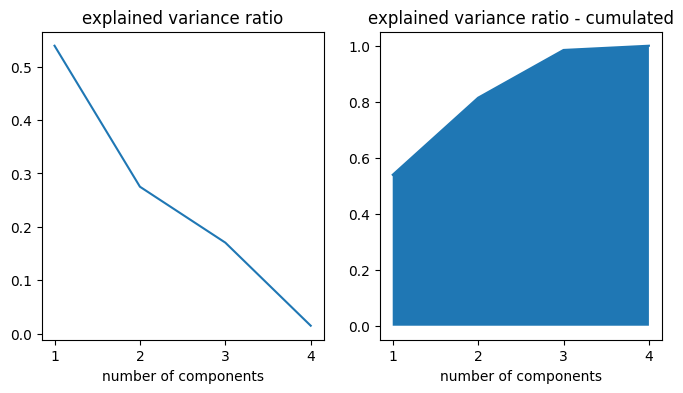

In [68]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(np.arange(1,5),pca.explained_variance_ratio_)
plt.title('explained variance ratio')
plt.xlabel('number of components')
plt.subplot(122)
plt.plot(np.arange(1,5),np.cumsum(pca.explained_variance_ratio_))
plt.fill_between(np.arange(1,5),np.cumsum(pca.explained_variance_ratio_))
plt.title('explained variance ratio - cumulated')
plt.xlabel('number of components')
plt.show()

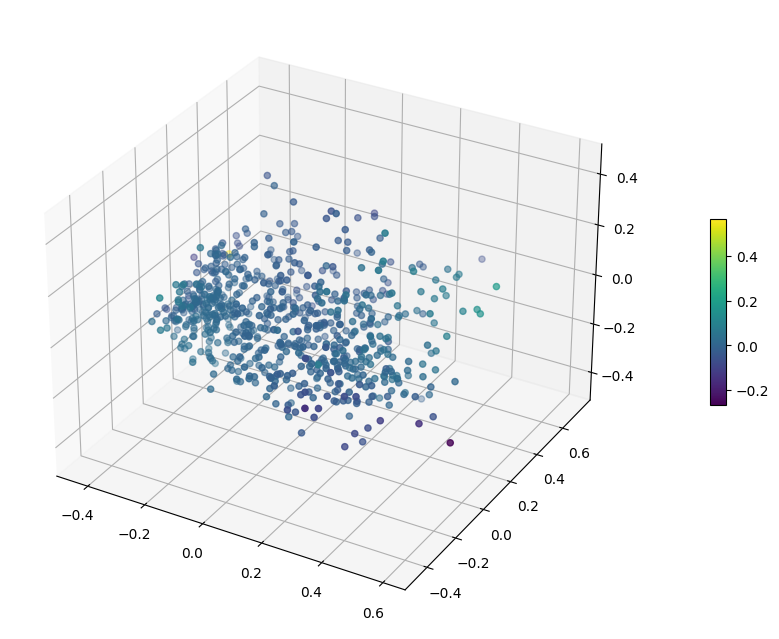

In [69]:
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(xs=X_pca[:,0], ys=X_pca[:,1], zs=X_pca[:,2], c=X_pca[:,3])
cax = fig.add_axes([ax.get_position().x1+0.10, ax.get_position().y0+0.14, 0.02, ax.get_position().height*0.3])
fig.colorbar(img, cax=cax)
plt.show()

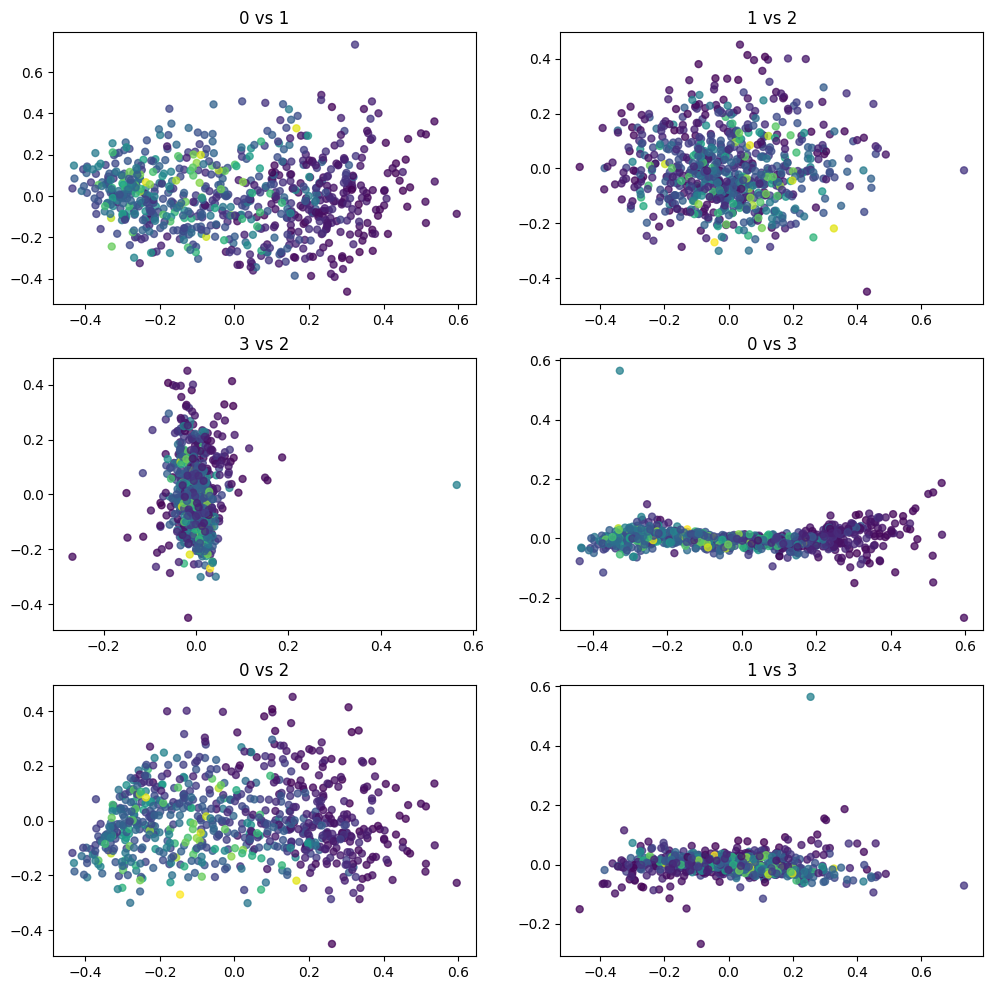

In [70]:
plt.figure(figsize=(12,12))
plt.subplot(321)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y.values, s=25, alpha=.75)
plt.title('0 vs 1')
plt.subplot(322)
plt.scatter(X_pca[:,1], X_pca[:,2], c=y.values, s=25, alpha=.75)
plt.title('1 vs 2')
plt.subplot(323)
plt.scatter(X_pca[:,3], X_pca[:,2], c=y.values, s=25, alpha=.75)
plt.title('3 vs 2')
plt.subplot(324)
plt.scatter(X_pca[:,0], X_pca[:,3], c=y.values, s=25, alpha=.75)
plt.title('0 vs 3')
plt.subplot(325)
plt.scatter(X_pca[:,0], X_pca[:,2], c=y.values, s=25, alpha=.75)
plt.title('0 vs 2')
plt.subplot(326)
plt.scatter(X_pca[:,1], X_pca[:,3], c=y.values, s=25, alpha=.75)
plt.title('1 vs 3')
plt.show()

# Porównanie modeli

## Model z PCA

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

In [80]:
# Podział na zmienne objaśniające i zmienną objaśnianą

X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

# Podział na zbiór treningowy i testowy
cv = KFold(n_splits=5, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('pca', PCA(random_state=42)),
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Tworzenie końcowego Pipeline, który będziemy trenować
final_pipeline_PCA = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])


In [81]:
final_pipeline_PCA.get_params()


{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('pca', PCA(random_state=42)),
                                                    ('logtransformer',
                                                     PowerTransformer()),
                                                    ('standardscaler',
                                                     StandardScaler()),
                                                    ('polynomialfeatures',
                                                     PolynomialFeatures())]),
                                    ['temp', 'hum', 'windspeed',
                                     'difference_temp']),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['season', 'mnth', 'holiday

In [82]:

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1),
          'preprocessor__num__pca__n_components': [1,2,3,4]}

gridsearch_PCA = GridSearchCV(final_pipeline_PCA,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv,
                                                      n_jobs=-1)

gridsearch_PCA.fit(X_train, y_train)
print("\nNajlepsze hiperparametry:", gridsearch_PCA.best_params_, "\n")

model_PCA = gridsearch_PCA.best_estimator_
predictions_PCA = model_PCA.predict(X_test)




Najlepsze hiperparametry: {'preprocessor__num__pca__n_components': 3, 'preprocessor__num__polynomialfeatures__degree': 2, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.1} 



In [83]:
PCA_score = model_PCA.score(X_test, y_test)

## Model - bez PCA

In [85]:

# Podział na zmienne objaśniające i zmienną objaśnianą
X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

# Podział na zbiór treningowy i testowy
cv = KFold(n_splits=5, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Tworzenie końcowego Pipeline, który będziemy trenować
final_pipeline_no_PCA = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])


In [86]:
final_pipeline_no_PCA.get_params()


{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('logtransformer',
                                                     PowerTransformer()),
                                                    ('standardscaler',
                                                     StandardScaler()),
                                                    ('polynomialfeatures',
                                                     PolynomialFeatures())]),
                                    ['temp', 'hum', 'windspeed',
                                     'difference_temp']),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['season', 'mnth', 'holiday', 'weekday',
                                     'workingday', 'weathersit'])])),

In [88]:

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

gridsearch_no_PCA = GridSearchCV(final_pipeline_no_PCA,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv,
                                                      n_jobs=-1)

gridsearch_no_PCA.fit(X_train, y_train)
print("\nNajlepsze hiperparametry:", gridsearch_no_PCA.best_params_, "\n")

model_no_PCA = gridsearch_no_PCA.best_estimator_
predictions_no_PCA = model_no_PCA.predict(X_test)




Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.30000000000000004} 



In [90]:
no_PCA_score = model_no_PCA.score(X_test, y_test)

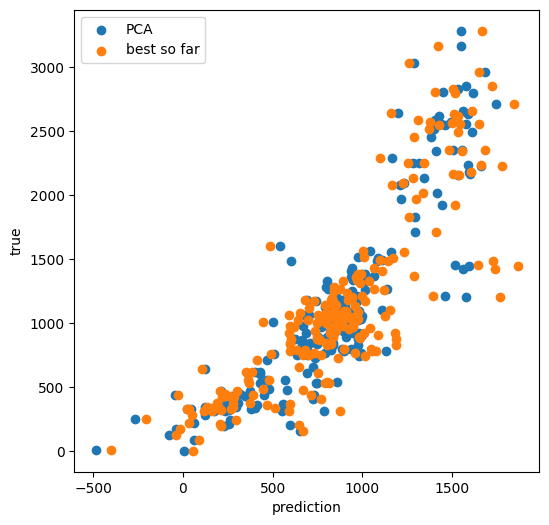

In [89]:
plt.figure(figsize=(6,6))
plt.scatter(predictions_PCA, y_test, label = 'PCA')
plt.scatter(predictions_no_PCA, y_test, label = 'best so far')
plt.xlabel('prediction')
plt.ylabel('true')
plt.legend()
plt.show()

In [93]:
print(f'Model bez PCA osiągnął score={no_PCA_score}, natomiast model z PCA osiągnął score={PCA_score}, czyli nieznacznie lepszy.')

Model bez PCA osiągnął score=0.4982978485680115, natomiast model z PCA osiągnął score=0.5085481263003975, czyli nieznacznie lepszy.
